In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import json
#from sklearn.preprocessing import LabelEncoder

### References

Review paper of random forest method
https://pdfs.semanticscholar.org/0a37/d219db73937b0c8f7ee7e2eec3427149e815.pdf
(This is the link of paper however we need to cite it right)

link that describes the TMDB dataset.
https://www.kaggle.com/tmdb/tmdb-movie-metadata
https://www.kaggle.com/c/tmdb-box-office-prediction

Feature engineering methods come from 
https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat

Parameter tuning methods come from 
https://juejin.im/post/5b7669c4f265da281c1fbf96

### Variable description

budget:Budget of a movie in dollars. 0 values mean unknown.

genres : Contains all the Genres Name & TMDB Id in JSON Format

homepage - Contains the official homepage URL of a movie. Example: http://sonyclassics.com/whiplash/ , this is the homepage of Whiplash movie.

movie_id - IMDB id of a movie (string). You can visit the IMDB Page like this: https://www.imdb.com/title/

original_language - Two digit code of the original language, in which the movie was made. Like: en = English, fr = french.

original_title - The original title of a movie. Title & Original title may differ, if the original title is not in English.

overview - Brief description of the movie.

popularity - Popularity of the movie in float.

production_companies - All production company name and TMDB id in JSON format of a movie.

production_countries - Two digit code and full name of the production company in JSON format.

release_date - Release date of a movie in mm/dd/yy format.

runtime - Total runtime of a movie in minutes (Integer).

spoken_languages - Two digit code and full name of the spoken language.

status - Is the movie released or rumored?

tagline - Tagline of a movie

title - English title of a movie

keywords - TMDB Id and name of all the keywords in JSON format.

cast - All cast TMDB id, name, character name, gender (1 = Female, 2 = Male) in JSON format

crew - Name, TMDB id, profile path of various kind of crew members job like Director, Writer, Art, Sound etc.

revenue - Total revenue earned by a movie in dollars

In [0]:
credits_link="https://raw.githubusercontent.com/alicexja/BoxOfficePrediction/master/tmdb_5000_credits.csv"
movies_link = "https://raw.githubusercontent.com/alicexja/BoxOfficePrediction/master/tmdb_5000_movies.csv"

credits = pd.read_csv(credits_link,encoding='iso-8859-1')
movies = pd.read_csv(movies_link,encoding='iso-8859-1')
df = pd.merge(credits,movies,how='right',on=['movie_id'])


In [0]:
df.columns

Index(['movie_id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26'],
      dtype='object')

In [0]:
df=df.drop(["title_y","Unnamed: 20","Unnamed: 21","Unnamed: 22","Unnamed: 23","Unnamed: 24","Unnamed: 25","Unnamed: 26"],axis=1)
df=df.drop(df[(df.status!="Released") & (df.status!="Rumored")&(df.status!="Post Production")].index)
df=df.drop(df[df.release_date.isna()].index)

In [0]:
df.shape

(4778, 22)

In [0]:
df.isna().sum()

movie_id                   0
title_x                    0
cast                       0
crew                       0
budget                     0
genres                     0
homepage                3070
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               0
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  834
vote_average               0
vote_count                 1
dtype: int64

In [0]:
df.head()

,movie_id,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009/12/10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800.0
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007/5/19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500.0
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bondâs past sends him...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015/10/26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466.0
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012/7/16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106.0
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012/3/7,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124.0


In [0]:
## first transform release dates to year,month,day and season
df[['release_year','release_month','release_day']]=df['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
df['release_year'] = df['release_year']
df.loc[ (df['release_year'] <= 19) & (df['release_year'] < 100), "release_year"] += 2000
df.loc[ (df['release_year'] > 19)  & (df['release_year'] < 100), "release_year"] += 1900  
releaseDate = pd.to_datetime(df['release_date']) 
df['release_dayofweek'] = releaseDate.dt.dayofweek 
df['release_quarter'] = releaseDate.dt.quarter     

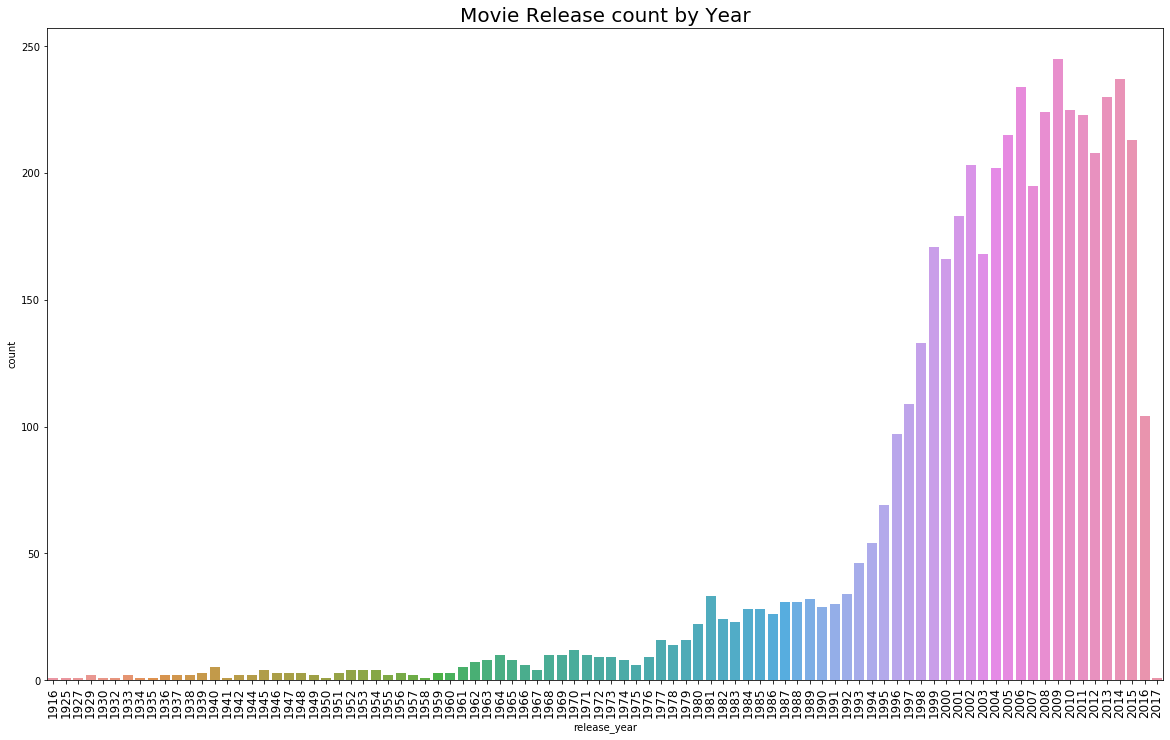

In [0]:
## let's see the number of movies released over years
plt.figure(figsize=(20,12))
sns.countplot(df['release_year'].sort_values())
plt.title("Movie Release count by Year",fontsize=20)
loc, labels = plt.xticks()
plt.xticks(fontsize=12,rotation=90)
plt.show()

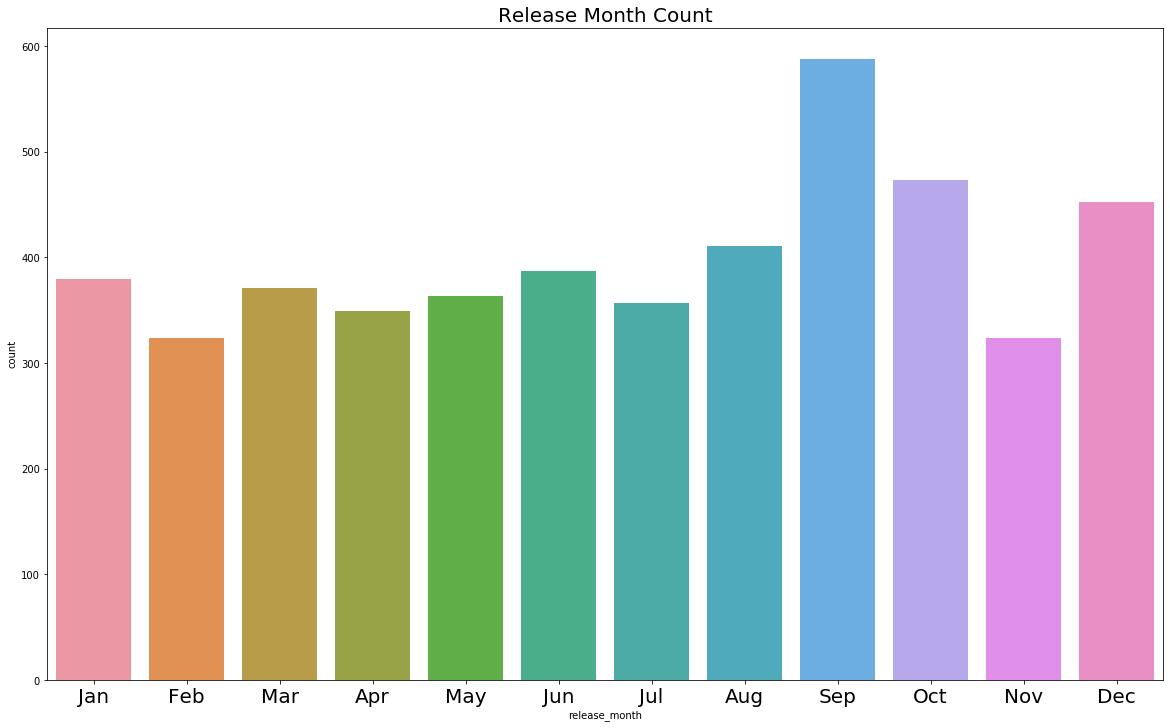

In [0]:
## is there any difference in release number of movies over months?
plt.figure(figsize=(20,12))
sns.countplot(df['release_month'].sort_values())
plt.title("Release Month Count",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

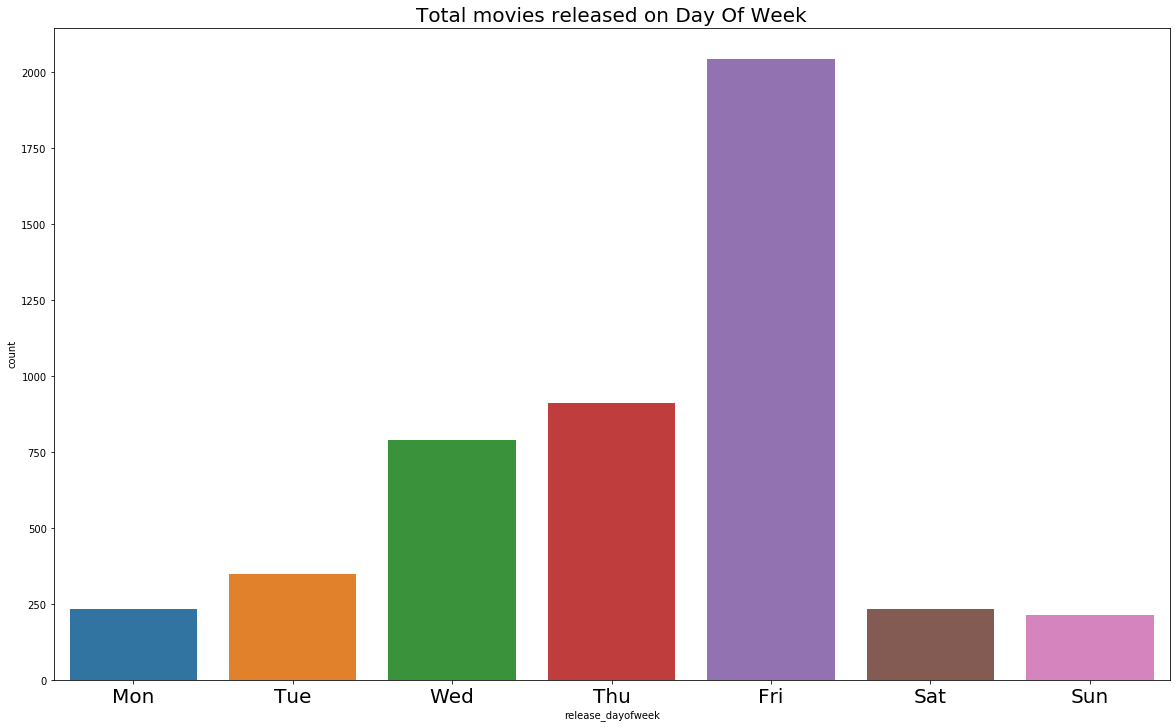

In [0]:
## release day of the week
plt.figure(figsize=(20,12))
sns.countplot(df['release_dayofweek'].sort_values())
plt.title("Total movies released on Day Of Week",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

In [0]:
## how many 0's are there in revenue and budget?
budget_0 = df[df.budget<=0].index
print("there are {} 0's in budget".format(len(budget_0)))
revenue_0 = df[df.revenue<=0].index
print("there are {} 0's in revenue".format(len(revenue_0)))

there are 1027 0's in budget
there are 1416 0's in revenue


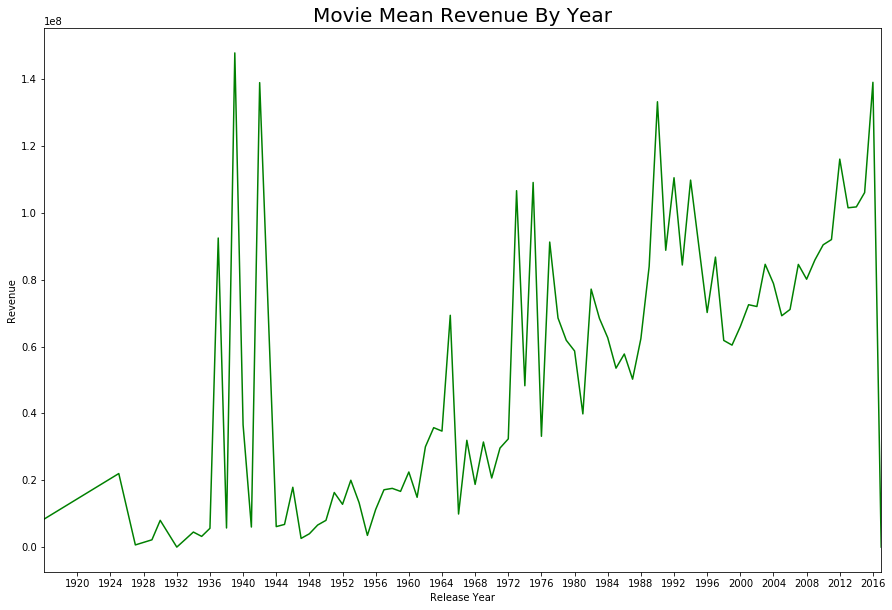

In [0]:
## plot revenue vs. year
## need to plot before filling 0's to avoid distortion.
revenue_year = df.groupby("release_year")["revenue"].aggregate('mean')
revenue_year.plot(figsize=(15,10),color="g")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Year",fontsize=20)
plt.show()

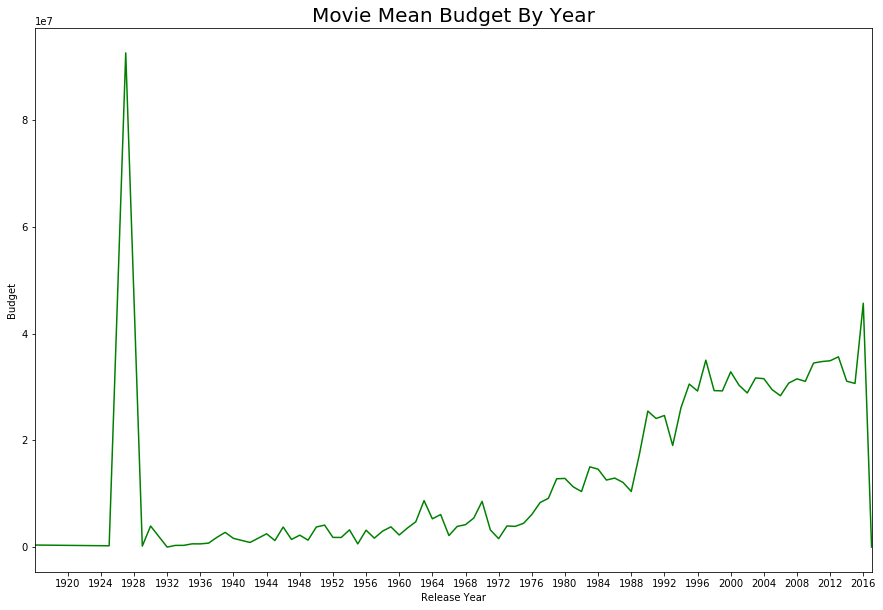

In [0]:
## plot budget vs. year
budget_year = df.groupby("release_year")["budget"].aggregate('mean')
budget_year.plot(figsize=(15,10),color="g")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Budget")
plt.title("Movie Mean Budget By Year",fontsize=20)
plt.show()

In [0]:
## we need to deal with them because budget and revenue shoudn't be 0
## replace the value with median
df.loc[df.revenue <=0,"revenue"] = df.revenue.median()
df.loc[df.budget<=0,"budget"]=df.budget.median()

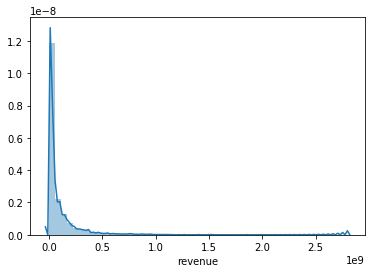

In [0]:
sns.distplot(df.revenue)

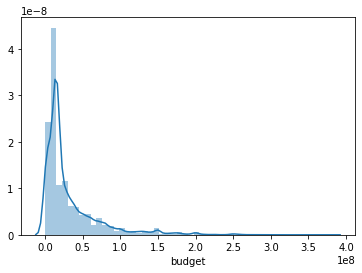

In [0]:
sns.distplot(df.budget)

In [0]:
## the revenue and budget are both right skewed. take log transformation to have normal distribution
df['originalRevenue'] = df.revenue
df.revenue=np.log1p(df.revenue)
df['inflationBudget'] = df['budget'] + df['budget']*1.8/100*(2019-df['release_year']) #Inflation simple formula
df['budget'] = np.log1p(df['budget']) 

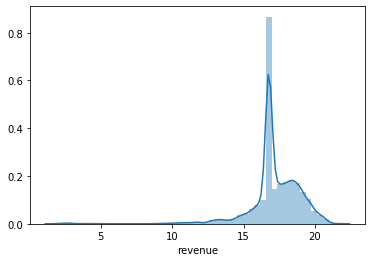

In [0]:
sns.distplot(df.revenue)
## they look much better now

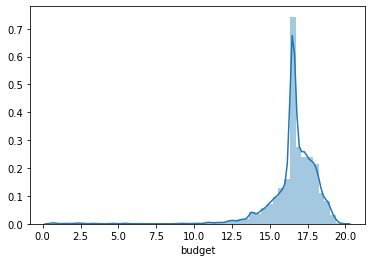

In [0]:
sns.distplot(df.budget)

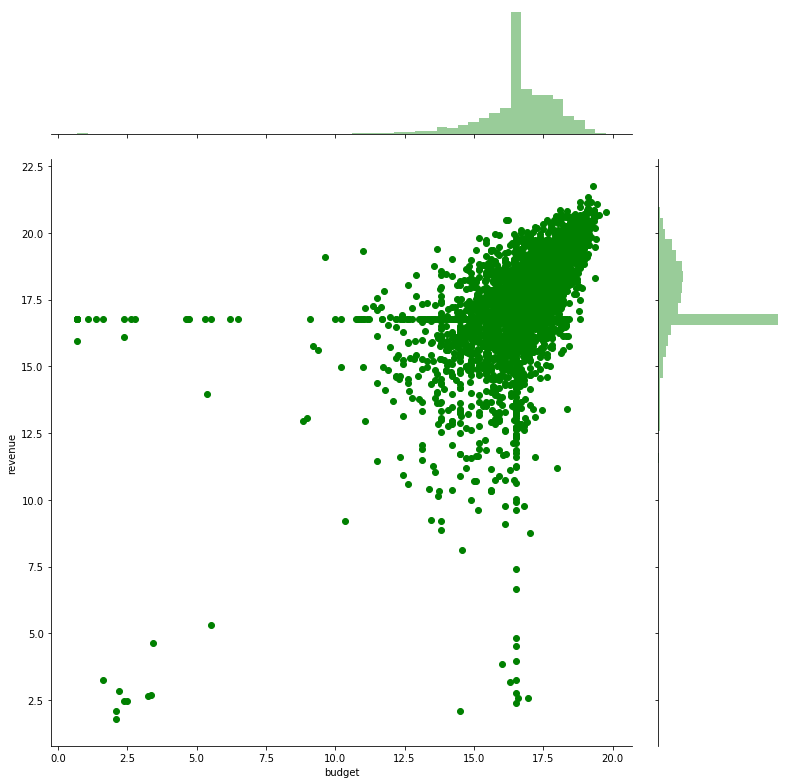

In [0]:
## let's see the log(budget) vs log(revenue)
sns.jointplot(x="budget", y="revenue", data=df, height=11, ratio=4, color="g")
plt.show()
## could identify a pretty strong relationship here

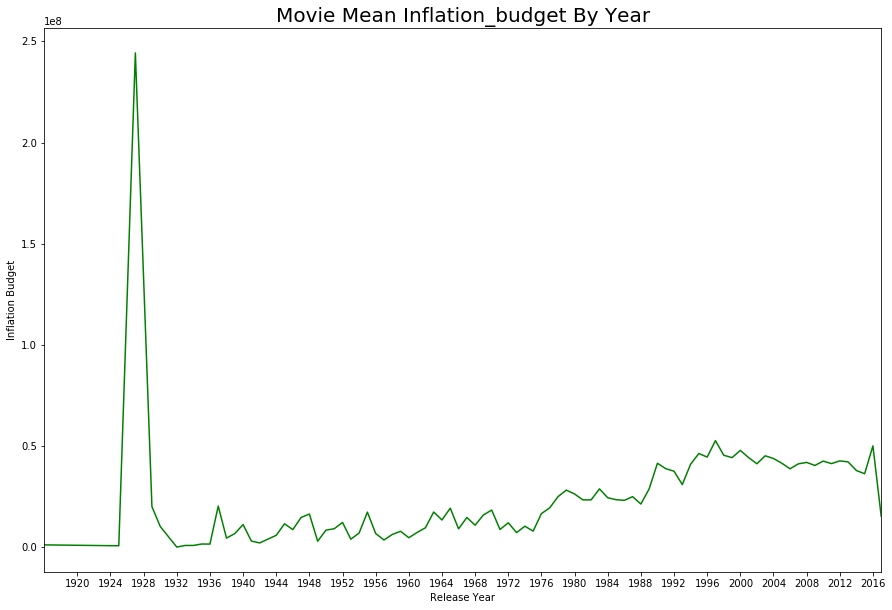

In [0]:
## how is inflation_budget vs time?
inflation_budget_year = df.groupby("release_year")["inflationBudget"].aggregate('mean')
inflation_budget_year.plot(figsize=(15,10),color="g")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Inflation Budget")
plt.title("Movie Mean Inflation_budget By Year",fontsize=20)
plt.show()

## after considering inflation factors, the change in budget became less obvious over the years.
## the unusual spike in 1924-1928 is because budget were missing in this 

In [0]:
## we could see some fields comtain json value instead of comma separated value
## deal with these fields
json_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords', 'cast', 'crew']

def get_dictionary(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

for col in tqdm(json_cols) :
    df[col] = df[col].apply(lambda x : get_dictionary(x))

## count the number of movies in each category    
def get_json_dict(df) :
    global json_cols
    result = dict()
    for e_col in json_cols :
        d = dict()
        rows = df[e_col].values
        for row in rows :
            if row is None : continue
            for i in row :
                if i['name'] not in d :
                    d[i['name']] = 0
                d[i['name']] += 1
        result[e_col] = d
    return result

df_dict = get_json_dict(df)

100%|██████████| 7/7 [00:04<00:00,  1.01s/it]


In [0]:
len(df_dict["genres"])+len(df_dict["production_companies"])+len(df_dict["production_countries"])+len(df_dict["spoken_languages"])
## the number of categorical variables there will be if we dummify without cleaning less frequently show up ones

5144

In [0]:
## there would be too many categorical variables if we dummify each category
# remove cateogry with low frequency in the dictionary (count of movies< 15)
for col in json_cols :
    
    remove = []
    df_id = set(list(df_dict[col].keys()))
    
    for i in df_id:
        if df_dict[col][i] < 15 or i == '' :
            remove += [i]
            
    for i in remove :
        if i in df_dict[col] :
            del df_dict[col][i]

In [0]:
len(df_dict["genres"])+len(df_dict["production_companies"])+len(df_dict["production_countries"])+len(df_dict["spoken_languages"])
## the number of dummy variables after dropping categories that show up less than 15 times.

161

In [0]:
## feature engineering
# since we are not going to handle natural language in this model, turn the keywords, overviews and titles etc to number of words.
df['num_keywords'] = df['keywords'].apply(lambda x: len(x) if x != {} else 0)
df['original_title_word_count'] = df['original_title'].str.split().str.len() 
df['title_word_count'] = df['title_x'].str.split().str.len()
df['overview_word_count'] = df['overview'].str.split().str.len()
df['tagline_word_count'] = df['tagline'].str.split().str.len()
df['cast_count'] = df['cast'].apply(lambda x : len(x))
df['crew_count'] = df['crew'].apply(lambda x : len(x))

# null value in fields homepage and tagline actually reveals information
df['has_homepage'] = 1
df.loc[pd.isnull(df['homepage']) ,"has_homepage"] = 0
    
df['has_tagline'] = 1
df.loc[pd.isnull(df['tagline']) ,"has_tagline"] = 0 

df['isOriginalLanguageEng'] = 0 
df.loc[ df['original_language'] == "en" ,"isOriginalLanguageEng"] = 1
    
#df['isTitleDifferent'] = 1
#df.loc[ df['original_title'] == df['title_x'] ,"isTitleDifferent"] = 0 
    
df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))


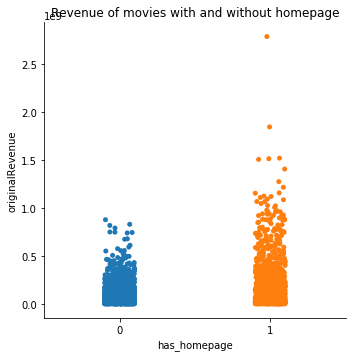

In [0]:
## how's homepage affecting revenue
sns.catplot(x="has_homepage", y="originalRevenue", data=df)
plt.title('Revenue of movies with and without homepage');
## the movie with homepage has higher revenue

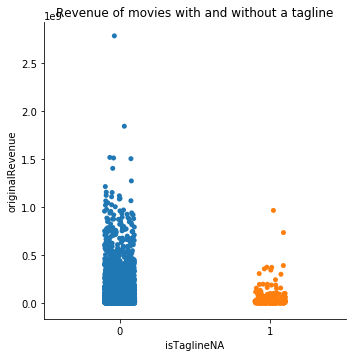

In [0]:

sns.catplot(x="has_tagline", y="originalRevenue", data=df)
plt.title('Revenue of movies with and without a tagline')

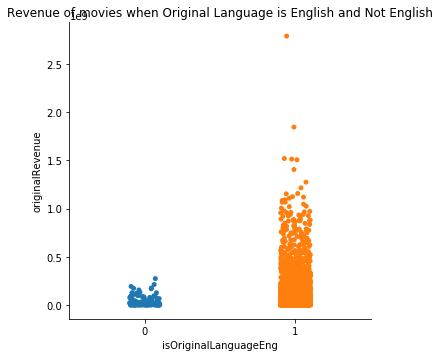

In [0]:
sns.catplot(x="isOriginalLanguageEng", y="originalRevenue", data=df)
plt.title('Revenue of movies when Original Language is English and Not English');

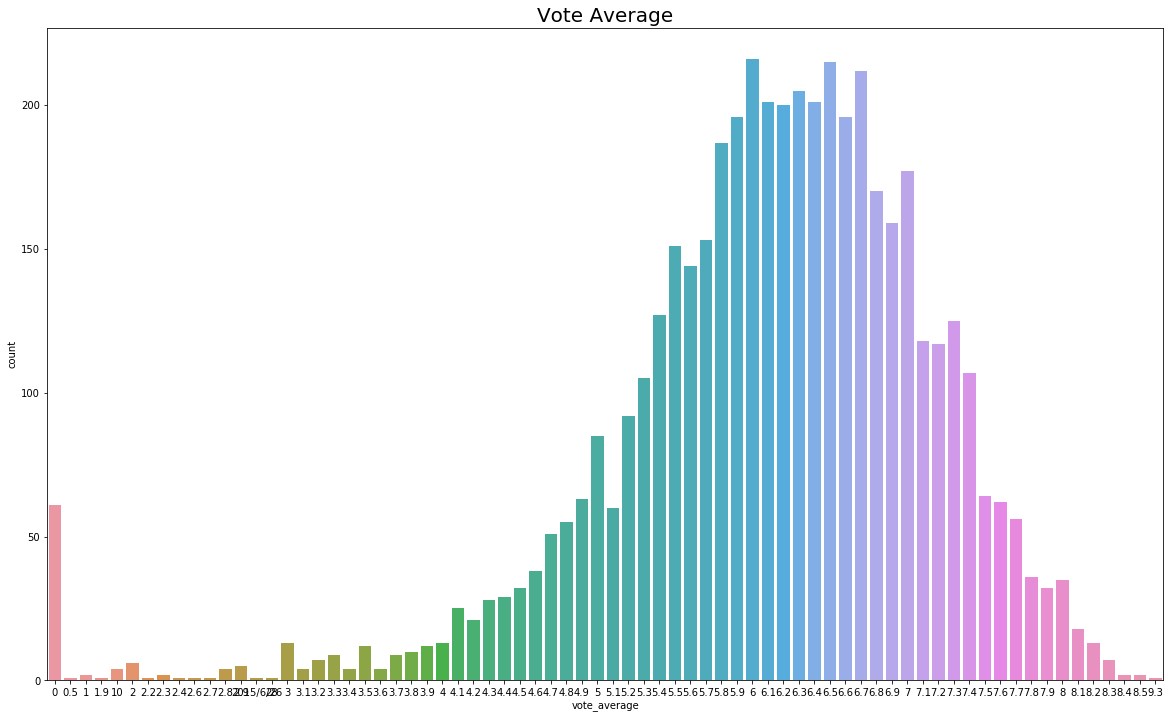

In [0]:
plt.figure(figsize=(20,12))
sns.countplot(df.vote_average.sort_values())
plt.title("Vote Average",fontsize=20)
plt.show()

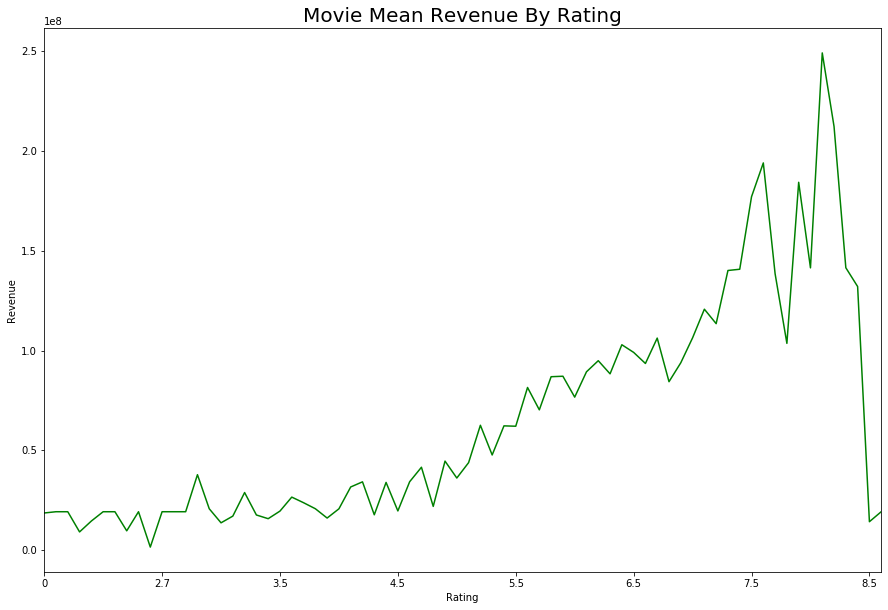

In [0]:
revenue_by_vote_average = df.groupby("vote_average")["originalRevenue"].aggregate('mean')
revenue_by_vote_average.plot(figsize=(15,10),color="g")
plt.xlabel("Rating")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Rating",fontsize=20)
plt.show()

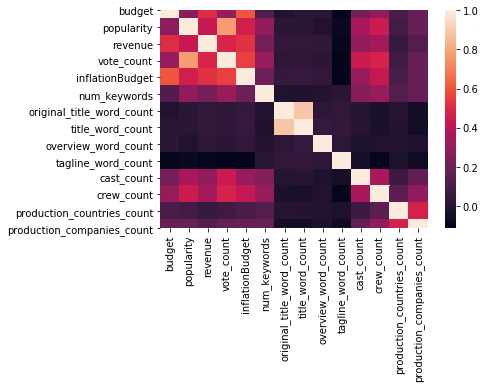

In [0]:
## before dummyfying categorical variables wee need to see the correlation of numeric variables
## to decide if there are any variables to drop
## see the correlation heatmap
cor = df[["budget","popularity","revenue","vote_count","inflationBudget","num_keywords",'original_title_word_count', 'title_word_count', 'overview_word_count','tagline_word_count', 'cast_count', 'crew_count','production_countries_count', 'production_companies_count']].corr()
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)

In [0]:
df.columns

Index(['movie_id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'vote_average', 'vote_count', 'release_year',
       'release_month', 'release_day', 'release_dayofweek', 'release_quarter',
       'inflationBudget', 'num_keywords', 'original_title_word_count',
       'title_word_count', 'overview_word_count', 'tagline_word_count',
       'cast_count', 'crew_count', 'has_homepage', 'isTaglineNA',
       'isOriginalLanguageEng', 'isTitleDifferent',
       'production_countries_count', 'production_companies_count'],
      dtype='object')

In [0]:
## apply the clean categories and dummify
for col in ['genres', 'production_countries', 'spoken_languages', 'production_companies'] :
        df[col] = df[col].map(lambda x: sorted(list(set([n if n in df_dict[col] else col+'_etc' for n in [d['name'] for d in x]])))).map(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1, sort=False)


In [0]:
## since popularity,vote_count and vote_average couldn't be obtained before movies are released, we will remove it from the predictors.
## remove text fields as well (genres, homepage, overview ...)
df = df.drop(df[df.vote_average == "2015/6/26"].index)
popularity = df.popularity.values;
release_dates = df.release_date.values;
df = df.drop(['movie_id','genres','homepage','overview','runtime'
    ,'production_companies','production_countries','release_date','spoken_languages','vote_average','vote_count'
    ,'status','title_x','keywords','cast','crew','original_language','original_title','tagline','popularity','originalRevenue'],axis=1)

In [0]:
df.columns

Index(['budget', 'revenue', 'vote_average', 'vote_count', 'release_year',
       'release_month', 'release_day', 'release_dayofweek', 'release_quarter',
       'inflationBudget',
       ...
       'United Artists', 'Universal Pictures', 'Vertigo Entertainment',
       'Village Roadshow Pictures', 'Walden Media', 'Walt Disney Pictures',
       'Warner Bros.', 'Wild Bunch', 'Working Title Films',
       'production_companies_etc'],
      dtype='object', length=187)

In [0]:
df.fillna(value=0,inplace=True)

In [0]:
## train test split
## calculate the test amount needed.

In [0]:
## train test split
from sklearn.model_selection import train_test_split
y=df.revenue.values
df=df.drop(['revenue'],axis=1)
xtrain,xtest,ytrain,ytest,train_date,test_date=train_test_split(df,y,release_dates,train_size=0.7,random_state=0,shuffle=True)

In [0]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(3343, 184)
(1434, 184)
(3343,)
(1434,)


In [0]:
xtrain.head(20)

,budget,release_year,release_month,release_day,release_dayofweek,release_quarter,inflationBudget,num_keywords,original_title_word_count,title_word_count,overview_word_count,tagline_word_count,cast_count,crew_count,has_homepage,has_tagline,isOriginalLanguageEng,production_countries_count,production_companies_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,genres_etc,Australia,...,New Regency Pictures,Nickelodeon Movies,Original Film,Orion Pictures,Paramount Pictures,Participant Media,Phoenix Pictures,Pixar Animation Studios,PolyGram Filmed Entertainment,Regency Enterprises,Relativity Media,Revolution Studios,Revolution Sun Studios,Scott Free Productions,Scott Rudin Productions,Screen Gems,Silver Pictures,Sony Pictures Classics,Spyglass Entertainment,Studio Babelsberg,Studio Canal,StudioCanal,Summit Entertainment,TF1 Films Production,TSG Entertainment,The Weinstein Company,Touchstone Pictures,TriStar Pictures,Twentieth Century Fox Film Corporation,UK Film Council,United Artists,Universal Pictures,Vertigo Entertainment,Village Roadshow Pictures,Walden Media,Walt Disney Pictures,Warner Bros.,Wild Bunch,Working Title Films,production_companies_etc
996,17.727534,2016,2,6,5,1,52700000.0,6,2,2,18.0,4.0,124,17,1,1,1,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
346,18.420681,2009,9,17,3,3,118000000.0,3,6,6,54.0,4.0,41,21,1,1,1,1,2,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
558,18.092177,2001,12,21,4,4,95328000.0,6,2,2,30.0,11.0,17,28,0,1,1,1,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3903,16.523561,2002,1,1,1,1,19590000.0,2,4,4,125.0,0.0,7,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1480,17.312018,2006,8,6,6,3,40722000.0,10,4,4,35.0,11.0,19,19,0,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2310,16.648724,1999,12,10,4,4,23120000.0,7,4,4,77.0,8.0,16,7,0,1,1,1,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4085,14.508658,2007,7,27,4,3,2432000.0,7,4,4,59.0,12.0,4,2,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2939,16.523561,2001,8,31,4,3,19860000.0,9,1,1,54.0,3.0,10,17,0,1,1,1,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
257,18.469471,2013,7,30,1,3,116340000.0,3,3,3,137.0,5.0,32,12,1,1,1,1,5,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1928,16.523561,2005,9,2,4,3,18780000.0,3,1,1,17.0,0.0,7,4,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
## we start with a simple MLR model as baseline model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
ppl=Pipeline([
        ("linear_regression",LinearRegression())
])
cvscore_mlr = cross_val_score(ppl,xtrain,ytrain,cv=5,scoring="neg_mean_squared_error")

In [0]:
print(cvscore_mlr.mean())

-2.1649009860565047


In [0]:
mlr = ppl.fit(xtrain,ytrain)
ypred_mlr=mlr.predict(xtest)
mse_test_mlr=(np.square(ytest - ypred_mlr)).mean()
mse_test_mlr

2.370167122212057

In [0]:
# use Random forst regressor
# starts with initial setting of params,see how it behaves 
# will tune later with gridsearch

rf = RandomForestRegressor(n_estimators=2000, # Number of trees to train. maybe 10,000 with colab.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=False, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=False,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores.
                       random_state=1, # Seed
                       verbose=0, # Set to 0 for silent training.
                       warm_start=False)


In [0]:
rf.fit(xtrain,ytrain)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0001, min_impurity_split=None,
                      min_samples_leaf=0.001, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [0]:
ypred=rf.predict(xtest)
mse_test_rf=(np.square(ytest - ypred)).mean()
mse_test_rf
## this is the test score before parameter tuning

3.083846816084841

In [0]:
cvscore_rf = cross_val_score(rf,xtrain,ytrain, cv=5, scoring="neg_mean_squared_error")

In [0]:
print(cvscore_rf.mean())
## this is the score we get before parameter tuning

-3.2129063213729374


In [0]:
## tune parameter: min_samples_split
## three models with min_samples_split = 2,5,10 will be created and compared
parameters = {
            'min_samples_split': [2,5,10]
}
gsearch = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_squared_error', cv=3)
gsearch.fit(xtrain, ytrain)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -3.078
Best parameters set:
	min_samples_split: 10


In [0]:
## tune another parameter: min_samples_leaf
parameters = {
            'min_samples_leaf': [0.001,0.005,0.01]
}
gsearch = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_squared_error', cv=3)
gsearch.fit(xtrain, ytrain)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -2.331
Best parameters set:
	min_samples_leaf: 0.01


In [0]:
## use the parameters we tuned to build a new model
## also increase the number of estimators from 2000 to 5000 because it's always going to be better
rf = RandomForestRegressor(n_estimators=5000, # Number of trees to train.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=10, # Minimum samples to create a split.
                       min_samples_leaf=0.01, # Minimum samples in a leaf. Accepts fractions for %. This is 1% of sample.
                       max_features='auto', 
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=False, 
                       oob_score=False,
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores.
                       random_state=1, # Seed
                       verbose=0, # Set to 0 for silent training.
                       warm_start=False)
rf.fit(xtrain,ytrain)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0001, min_impurity_split=None,
                      min_samples_leaf=0.01, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=5000,
                      n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [0]:
ypred=rf.predict(xtest)
mse_test_rf=(np.square(ytest - ypred)).mean()
mse_test_rf
## this is the test score after parameter tuning

2.480736267617681

In [0]:
cvscore_rf = cross_val_score(rf,xtrain,ytrain, cv=5, scoring="neg_mean_squared_error")

In [0]:
cvscore_rf.mean()
## this is the cvscore after parameter tuning on random forest

-2.317542755438305

In [0]:
## see which predictors are important
for name, importance in zip(xtrain.columns, rf.feature_importances_):
    print(name, "= %.2f" % importance)
## important predictors:inflationBudget,release year, cast count, crew cocunt,num_keywords 

budget = 0.15
release_year = 0.03
release_month = 0.00
release_day = 0.01
release_dayofweek = 0.01
release_quarter = 0.00
inflationBudget = 0.66
num_keywords = 0.03
original_title_word_count = 0.00
title_word_count = 0.00
overview_word_count = 0.01
tagline_word_count = 0.00
cast_count = 0.04
crew_count = 0.04
has_homepage = 0.00
has_tagline = 0.00
isOriginalLanguageEng = 0.00
production_countries_count = 0.00
production_companies_count = 0.00
Action = 0.00
Adventure = 0.00
Animation = 0.00
Comedy = 0.00
Crime = 0.00
Documentary = 0.00
Drama = 0.00
Family = 0.00
Fantasy = 0.00
Foreign = 0.00
History = 0.00
Horror = 0.00
Music = 0.00
Mystery = 0.00
Romance = 0.00
Science Fiction = 0.00
Thriller = 0.00
War = 0.00
Western = 0.00
genres_etc = 0.00
Australia = 0.00
Belgium = 0.00
Canada = 0.00
China = 0.00
Czech Republic = 0.00
Denmark = 0.00
France = 0.00
Germany = 0.00
Hong Kong = 0.00
India = 0.00
Ireland = 0.00
Italy = 0.00
Japan = 0.00
Mexico = 0.00
Netherlands = 0.00
New Zealand = 0.00

In [0]:
##### for xgboosting
## the initial model before param tuning
xg = GradientBoostingRegressor( # How to calculate losses. Deviance is for probabilistic outputs. Alternative exponential for AdaBoost. 
                           learning_rate=0.1, # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                           n_estimators=2000, # How many trees to use, the more the better, but decrease learning rate if many used.
                           subsample=0.632, # Subsampling to use. 63.2% of data is standard for XGBoost.But The gridsearch gives 0.8 to be better.
                           criterion='friedman_mse', # Error to use for each split. Good idea to leave it as is.
                           min_samples_split=2, # Minimum samples for a split.
                           min_samples_leaf=1, # Minimum samples in a leaf.
                           min_weight_fraction_leaf=0.0, # Minimum fraction of samples in a leaf. Consider increasing if first few trees too good.
                           max_depth=3, # Maximum depth.
                           min_impurity_decrease=0.01, # Minimum impurity decrease. Might want to use 1% or so.
                           init=None, # How to make first prediction (it needs one). Can give model that supports fit and predict.
                           random_state=1, # Seed
                           max_features='auto', # Same as RF. 
                           verbose=0,  # Same as RF.
                           max_leaf_nodes=None,  # Same as RF.
                           warm_start=False,  # Same as RF.
                           presort='auto', # Whether to presort the data to speed up training.
                           validation_fraction=0.3, # XGBoost CAN overfit, so control this just in case. Uses 30% validation in this case.
                           n_iter_no_change=None, # Iters to stop training if no change occurs between one tree and the next.
                           tol=0.0001 # Tolerance. Means maximum change of 10^-4
                          )
xg.fit(xtrain,ytrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.01, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='auto', random_state=1,
                          subsample=0.632, tol=0.0001, validation_fraction=0.3,
                          verbose=0, warm_start=False)

In [0]:
ypred_xg=xg.predict(xtest)
mse_test_xg=(np.square(ytest - ypred_xg)).mean()
mse_test_xg
## test score of xgboosting before param tuning

2.5624763114781164

In [0]:
cvscore_xg = cross_val_score(xg,xtrain,ytrain, cv=5, scoring="neg_mean_squared_error")

In [0]:
cvscore_xg.mean()
## cv score of xg before param tuning

-2.3243816951059317

In [0]:
## tune param:max_depth

parameters = {
 'max_depth':[3,5,10,15]
}
gsearch = GridSearchCV(xg, param_grid=parameters, scoring='neg_mean_squared_error', cv=3)
gsearch.fit(xtrain, ytrain)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Best score: -2.256
Best parameters set:
	max_depth: 5


In [0]:
## tune param:min_samples_split

parameters = {
 'min_samples_split':[2,5,10]
}
gsearch = GridSearchCV(xg, param_grid=parameters, scoring='neg_mean_squared_error', cv=3)
gsearch.fit(xtrain, ytrain)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -2.151
Best parameters set:
	min_samples_split: 2


In [0]:
## tune param:learning rate
parameters = {
 'learning_rate':[0.05,0.1]
}
gsearch = GridSearchCV(xg, param_grid=parameters, scoring='neg_mean_squared_error', cv=3)
gsearch.fit(xtrain, ytrain)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -2.219
Best parameters set:
	min_samples_split: 0.05


In [0]:
## now we rebuild xgboosting model with best params we got.
## also set number of estimators to 5000 to have better performance
xg = GradientBoostingRegressor( 
                           learning_rate=0.05, # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                           n_estimators=5000, # How many trees to use, the more the better
                           subsample=0.8, # Subsampling to use. The gridsearch gives 0.8 to be better.
                           criterion='friedman_mse', # Error to use for each split. Good idea to leave it as is.
                           min_samples_split=2, # obtained from param tuning
                           min_samples_leaf=1, # Minimum samples in a leaf.
                           min_weight_fraction_leaf=0.0, # Minimum fraction of samples in a leaf. Consider increasing if first few trees too good.
                           max_depth=5, # obtained from param tuning
                           min_impurity_decrease=0.01, # Minimum impurity decrease. Might want to use 1% or so.
                           init=None, 
                           random_state=1, # Seed
                           max_features='auto', # Same as RF. 
                           verbose=0,  # Same as RF.
                           max_leaf_nodes=None,  # Same as RF.
                           warm_start=False,  # Same as RF.
                           presort='auto', # Whether to presort the data to speed up training.
                           validation_fraction=0.3, # XGBoost CAN overfit.Uses 30% validation in this case.
                           n_iter_no_change=None, # Iters to stop training if no change occurs between one tree and the next.
                           tol=0.0001 # Tolerance. Means maximum change of 10^-4
                          )

In [0]:
xg.fit(xtrain,ytrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=5,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.01, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=5000,
                          n_iter_no_change=None, presort='auto', random_state=1,
                          subsample=0.8, tol=0.0001, validation_fraction=0.3,
                          verbose=0, warm_start=False)

In [0]:
ypred_xg=xg.predict(xtest)
mse_test_xg=(np.square(ytest - ypred_xg)).mean()
mse_test_xg
## mse on test set after param tuning

2.371746599761329

In [0]:
cvscore_xg = cross_val_score(xg,xtrain,ytrain, cv=5, scoring="neg_mean_squared_error")

In [0]:
print(cvscore_xg.mean())
## cv score of xgboosting after param tuning

In [0]:
for name, importance in zip(xtrain.columns, xg.feature_importances_):
  print(name, "= %.2f" % importance)
## there are more predictors having importance than in random forest

In [0]:
test_date = test_date.apply(lambda x:x=x[:])

array(['2015/9/21', '2008/8/22', '2012/8/16', '2000/7/19', '2001/5/15',
       '2009/11/13', '1997/1/24', '2014/5/14', '2011/8/18', '2015/7/29'],
      dtype=object)

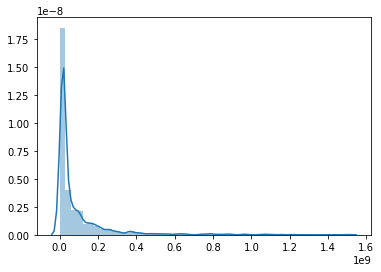

In [0]:
## how the predicted revenue differ from true revenue?
sns.distplot(np.exp(ytest))
## take 0.4*e^9 as cutoff for low and hight revenue movie

In [0]:
low_rev_test_idx, = np.where(np.exp(ytest) < np.exp(9)/0.1)
len(low_rev_test_idx)

168

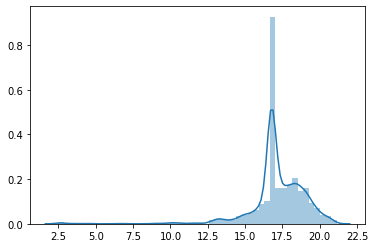

In [0]:
sns.distplot(ytest)

In [0]:
low_rev_test_idx, = np.where(ytest < 13)
len(low_rev_test_idx)

32

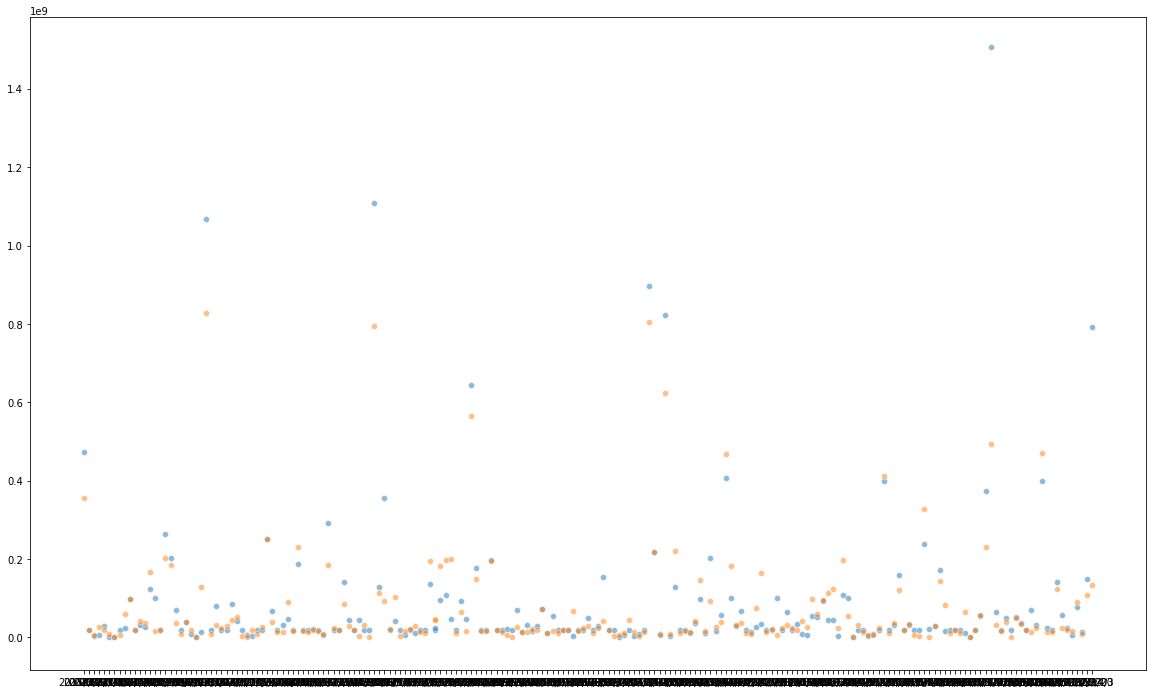

In [0]:
plt.figure(figsize=(20,12))
sns.scatterplot(y=np.exp(ytest[:200]),x=test_date[:200],alpha=0.5)
sns.scatterplot(y=np.exp(ypred_xg[:200]),x=test_date[:200],alpha=0.5)
#sns.distplot(ypred_xg)

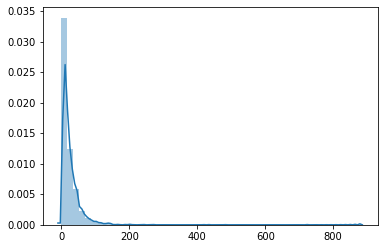

In [0]:
##NO MORE. we would also like to predict whether the movie will be popular. 
## The response variable here will be "popularity" we just dropped
## we take median as cutoff value.
sns.distplot(popularity)

In [0]:
## pop is the categorical variable for popularity
pop=np.ndarray(len(popularity))
for i in range(len(popularity)):
  if popularity[i]<np.median(popularity):
    pop[i]=0
  else:
    pop[i]=1
xtrain,xtest,ytrain,ytest=train_test_split(df,pop,train_size=0.7,random_state=0,shuffle=True)

In [0]:
y.mean()

17.206076873694514